# Data Mining Exercise:

----
# 1. Look at the big picture  
### Issue:  
Accidentes automovilísticos en Barcelona.  
Detectar las zonas más peligrosas y reducir las víctimas.

- ¿Supervisada, no supervisada o Aprendizaje Reforzado?  
**Supervisada.**
- ¿Clasificación, Regresión u otra cosa?  
**Regresión.**
- ¿Aprendizaje en Batch o con técnicas de aprendizaje online?  
**...**

---  
# 2. Get the data.


In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
df = pd.read_csv('dataset.csv')

---
# 3. Discover and visualize the data to gain insights.

In [2]:
df.info()
#df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824587 entries, 0 to 824586
Data columns (total 6 columns):
GridID            824587 non-null int64
date              824587 non-null object
Shift             824587 non-null object
Accident          824587 non-null int64
Longitude.grid    824587 non-null float64
Latitude.grid     824587 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 37.7+ MB


In [3]:
df.dtypes

GridID              int64
date               object
Shift              object
Accident            int64
Longitude.grid    float64
Latitude.grid     float64
dtype: object

In [4]:
df.head()

,GridID,date,Shift,Accident,Longitude.grid,Latitude.grid
0,1,2010-10-08,Night,0,2.08,41.41
1,1,2011-02-16,Morning,0,2.08,41.41
2,1,2014-05-31,Night,0,2.08,41.41
3,1,2011-04-03,Afternoon,0,2.08,41.41
4,1,2013-02-20,Morning,0,2.08,41.41


Realiza un ***df.describe()*** en este caso no es bastante revelador, por lo tanto se omitirá.

In [5]:
dummies = pd.get_dummies(df["Shift"])
df = pd.concat([df, dummies], axis = 1)

In [6]:
df = df.drop("Shift",1)
df = df.drop("date",1)
df = df[['GridID', 'Longitude.grid', 'Latitude.grid', 'Afternoon','Morning','Night', 'Accident']]
df.head()

,GridID,Longitude.grid,Latitude.grid,Afternoon,Morning,Night,Accident
0,1,2.08,41.41,0,0,1,0
1,1,2.08,41.41,0,1,0,0
2,1,2.08,41.41,0,0,1,0
3,1,2.08,41.41,1,0,0,0
4,1,2.08,41.41,0,1,0,0


In [7]:
X = np.array(df.drop(['Accident'],1))
y = np.array(df['Accident'])
X.shape

(824587, 6)

In [8]:
model = linear_model.LogisticRegression()
model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [9]:
predictions = model.predict(X)
print(predictions[0:5])

[0 0 0 0 0]


In [10]:
model.score(X,y)

0.9557148002575835

In [11]:
validation_size = 0.20
seed = 7
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=validation_size, random_state=seed)

In [12]:
name = 'Logistic Regression'
kfold = model_selection.KFold(n_splits=10,random_state=seed)
cv_results = model_selection.cross_val_score(model,X_train,y_train,cv=kfold,scoring='accuracy')
msg="%s: %f (%f)" %(name,cv_results.mean(),cv_results.std())
print(msg)

Logistic Regression: 0.955605 (0.000985)


In [13]:
predictions = model.predict(X_test)
print(accuracy_score(y_test,predictions))

0.956153967426236


In [14]:
print(confusion_matrix(y_test,predictions))

[[157687      0]
 [  7231      0]]


In [15]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98    157687
          1       0.00      0.00      0.00      7231

avg / total       0.91      0.96      0.93    164918



C:\Users\alter\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 1. Up-sample Minority Class  
Es el proceso de ducplicacion alietoria de observaciones desde la clase minoritaria como objetivo de reforzar la señal.

In [16]:
from sklearn.utils import resample

In [17]:
df_majority = df[df.Accident == 0]
df_minority = df[df.Accident == 1]

df_minority_unsampled = resample(df_minority,
                                replace = True,
                                n_samples= 788070,
                                random_state = 123)

df_upsampled = pd.concat([df_majority,df_minority_unsampled])

df_upsampled.Accident.value_counts()

1    788070
0    788070
Name: Accident, dtype: int64

In [18]:
from sklearn.linear_model import LogisticRegression
X = df_upsampled.drop('Accident', axis=1)
y = df_upsampled.Accident

#train
clf_1 = LogisticRegression().fit(X,y)

#predict on training set
pred_y_1 =clf_1.predict(X)

In [19]:
print(np.unique(pred_y_1))

[0 1]


In [20]:
print(accuracy_score(y,pred_y_1))

0.6235937162942379


## 2. Down-sample Majority Class
Down-sampling envuelve remove observacinoes alietoriamente desde la clase mayoritaria para prevenir esta señal que interfiere con el algoritmo

In [21]:
df_majority = df[df.Accident == 0]
df_minority = df[df.Accident == 1]

df_majority_downsampled = resample(df_majority,
                                replace = False,
                                n_samples= 36517,
                                random_state = 123)

df_downsampled = pd.concat([df_majority_downsampled,df_minority])

df_downsampled.Accident.value_counts()

1    36517
0    36517
Name: Accident, dtype: int64

In [22]:
from sklearn.linear_model import LogisticRegression
X = df_downsampled.drop('Accident', axis=1)
y = df_downsampled.Accident

#train
clf_2 = LogisticRegression().fit(X,y)

#predict on training set
pred_y_2 = clf_2.predict(X)

In [23]:
print(np.unique(pred_y_2))

[0 1]


In [24]:
print(accuracy_score(y,pred_y_2))

0.6245995016019936


# 3. Change performance Metric  
hasta ahora hemos visto dos maneras de normalizar clases imbalanceadas resampleando el dataset. Lo siguiente, veremos el uso de otras metricas de desempeño para evaluar los modelos.

In [25]:
from sklearn.metrics import roc_auc_score
prob_y_2 = clf_2.predict_proba(X)

prob_y_2 = [p[1] for p in prob_y_2]

prob_y_2[:5]

[0.5473974925682503,
 0.27203248045509043,
 0.5951469088174705,
 0.5666033163755032,
 0.2198151598629246]

In [26]:
print(roc_auc_score(y,prob_y_2))

0.6401236116361313


In [27]:
#probar aqui con el primer modelo

## 4. Penalize Algorithms(Cost_Sensitive Training)  
La siguiente tactica es usar algoritmos de aprendizaje penalizadores¿? que incremente el costo de los errores de clasificacion en la clase minoritaria.

In [ ]:
from sklearn.svm import SVC 
X = df_downsampled.drop('Accident', axis=1)
y = df_downsampled.Accident

clf_3 = SVC(kernel = 'linear',
            class_weight = 'balanced', 
            probability = True)

clf_3.fit(X,y)

pred_y_3 = clf_3.predict(X)

print(np.unique(pred_y_3))

In [ ]:
print(accuracy_score(y,pred_y_3))

In [ ]:
prob_y_3 = clf_3.predict_proba(X)
prob_y_3 = [p[1] for p in prob_y_3]
print(roc_auc_score(y,prob_y_3))

## 5. Use Tree-Based Algorithms  
La táctica  finala bine considerada es usar algoritmos de arboles de decision. Los arboles de decision a menudo se desempeñan bine sobre datasets no balaceados porque su estructura jerarquica permite aprender señales desde ambas clases.  
En el aprendizaje automatico  moderno aplicado, los conjuntos de arboles (Random Forests, Gradient Boosted Trees, etc.) casi siempre superan a los arboles de decision singulares.

In [27]:
from sklearn.ensemble import RandomForestClassifier

C:\Users\alter\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [28]:
X = df_downsampled.drop('Accident', axis=1)
y = df_downsampled.Accident

clf_4 = RandomForestClassifier()
clf_4.fit(X,y)

pred_y_4 = clf_4.predict(X)

print(np.unique(pred_y_4))

[0 1]


In [29]:
print(accuracy_score(y,pred_y_4))

0.746693320919024


In [30]:
prob_y_4 = clf_4.predict_proba(X)
prob_y_4 = [p[1] for p in prob_y_4]
print(roc_auc_score(y,prob_y_4))

0.8242301131372446


---

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size=0.30,random_state=1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier(criterion = 'entropy', random_state = 1)

In [ ]:
DTC.fit(X_train,y_train)

In [ ]:
y_train_pred = DTC.predict_proba(X_train)

In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train, y_train_pred[:,1]), "Arbol de desicion - Datos de entrenamiento ")

In [ ]:
y_test_pred = DTC.predict_proba(X_train)
print(roc_auc_score(y_test,y_test_pred[:,1]),)

---

In [6]:
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

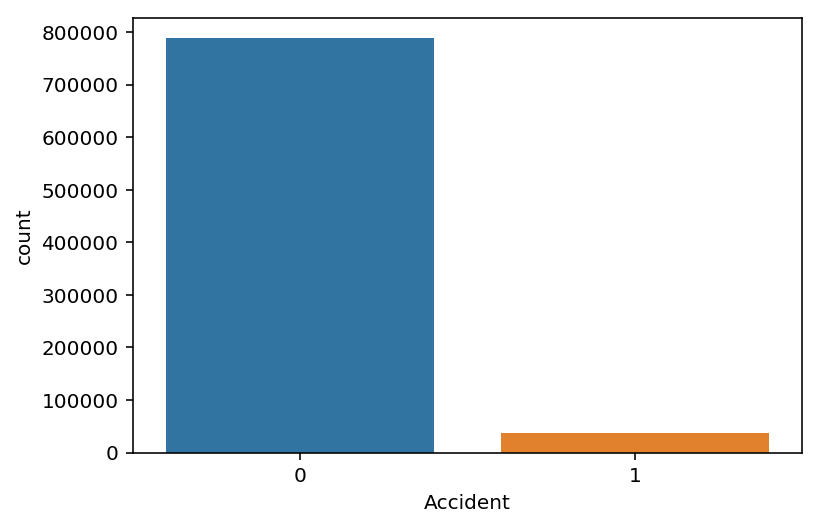

In [7]:
sns.countplot(x="Accident",data=df);

In [8]:
df["Accident"].value_counts()

0    788070
1     36517
Name: Accident, dtype: int64

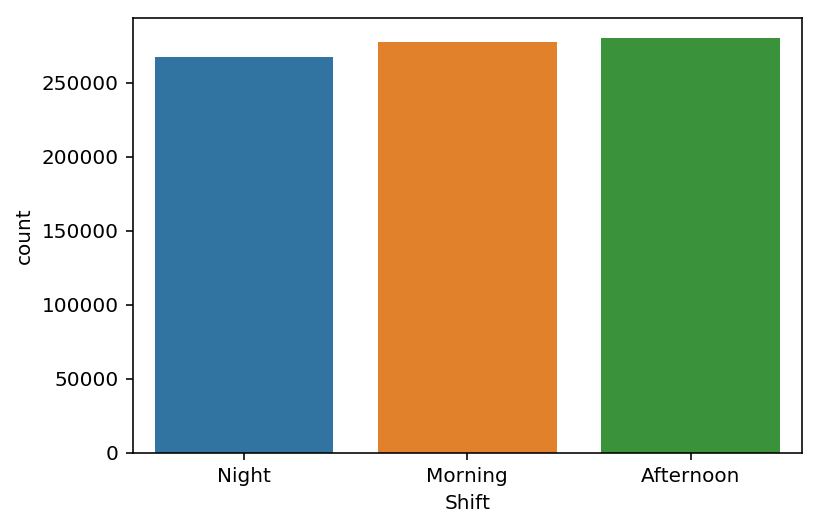

In [9]:
sns.countplot(x="Shift", data=df);

In [10]:
df["Shift"].value_counts()

Afternoon    279847
Morning      277391
Night        267349
Name: Shift, dtype: int64

In [11]:
happen = df[df['Accident'] == 1]
print(happen)

        GridID        date      Shift  Accident  Longitude.grid  \
466          1  2011-01-26  Afternoon         1          2.0800   
765          2  2014-01-31    Morning         1          2.0825   
3113         6  2013-05-26    Morning         1          2.0925   
3733         7  2013-05-26    Morning         1          2.0925   
3781         7  2010-07-21  Afternoon         1          2.0925   
3893         8  2014-04-08  Afternoon         1          2.0925   
4167         8  2014-11-28  Afternoon         1          2.0925   
4661         9  2012-05-14    Morning         1          2.0925   
5104        10  2010-01-26    Morning         1          2.0950   
5220        10  2010-12-22    Morning         1          2.0950   
5706        11  2011-02-12  Afternoon         1          2.0950   
5735        11  2012-03-01    Morning         1          2.0950   
5741        11  2011-01-17  Afternoon         1          2.0950   
6166        12  2010-07-12      Night         1          2.095

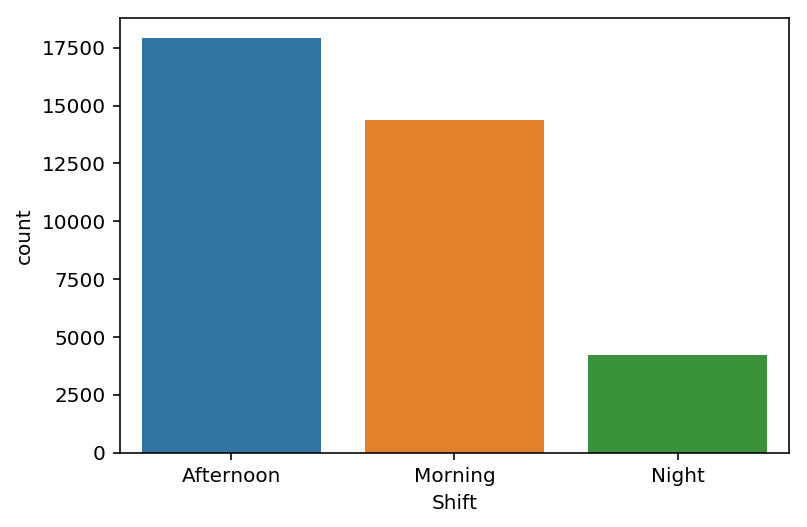

In [12]:
sns.countplot(x="Shift", data=happen);

In [13]:
happen["Shift"].value_counts()

Afternoon    17906
Morning      14375
Night         4236
Name: Shift, dtype: int64

In [14]:
dummies = pd.get_dummies(df["Accident"])
print(dummies)

        0  1
0       1  0
1       1  0
2       1  0
3       1  0
4       1  0
5       1  0
6       1  0
7       1  0
8       1  0
9       1  0
10      1  0
11      1  0
12      1  0
13      1  0
14      1  0
15      1  0
16      1  0
17      1  0
18      1  0
19      1  0
20      1  0
21      1  0
22      1  0
23      1  0
24      1  0
25      1  0
26      1  0
27      1  0
28      1  0
29      1  0
...    .. ..
824557  1  0
824558  1  0
824559  1  0
824560  1  0
824561  1  0
824562  1  0
824563  1  0
824564  1  0
824565  1  0
824566  1  0
824567  1  0
824568  1  0
824569  1  0
824570  1  0
824571  1  0
824572  1  0
824573  1  0
824574  1  0
824575  1  0
824576  1  0
824577  1  0
824578  1  0
824579  1  0
824580  1  0
824581  1  0
824582  1  0
824583  1  0
824584  1  0
824585  1  0
824586  1  0

[824587 rows x 2 columns]


In [ ]:
dummiesS = pd.get_dummies(df["Shift"])
print(dummiesS)

---
## Visualizaciones  

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
df.plot(kind = "Scatter", x ="Longitude.grid", y = "Latitude.grid", alpha = 0.001999999)
plt.grid(True)

In [ ]:
happen.plot(kind = "Scatter", x ="Longitude.grid", y = "Latitude.grid", alpha = 0.01)
plt.grid(True)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

---  
# 4. Prepare the data for Machine Learning algorithms.  
## Create a Test Set

In [ ]:
df = pd.concat([df, dummies], axis = 1)
df.head()

In [ ]:
df = pd.concat([df, dummiesS], axis = 1)
df.head()

In [ ]:
import numpy as np 
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(df, 0.2)
print(len(train_set), "Train +", len(test_set),"Test")

--- 

In [ ]:
df.sort_values(by="date")

## Operaciones  

In [ ]:
df.mean

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
happen['date']= pd.to_datetime(happen['date'])
happen.set_index('date', inplace=True)

happen[['Accident']].plot(figsize=(16,8), color = 'royalblue', linewidth=2,fontsize=14)
plt.xlabel('Años', fontsize=14)

In [ ]:
X = df[[]]

---- 
# 5. Select a model and train it.

---  
# 6. Fine-tune your model.

---  
# 7. Present your solution.

---  
# 8. Launch, monitor, and maintain your system.